# Introduction

This notebook uses Twitter data found [here](https://data.world/crowdflower/brands-and-product-emotions) for natural language processing, with the goal of **predicting the sentiment of a tweet.** It follows the basic format of loading, cleaning, and preprocessing data. The data is then fed into **seven machine learning models** with varying architectures. A final validation accuracy of **70.41%** is achieved.

## Packages

In [1]:
import pandas as pd
pd.set_option("max_columns", None)

import numpy as np
np.random.seed(0)

import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

from sklearn.model_selection import train_test_split

import re

import string

from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Preview Data

Let's take a basic look at the data. It's obvious here that some **personal information still needs to be scrubbed,** such as usernames. Moreover, there's a lot of superfluous **punctuation** and use of **hashtags** that we need to filter out before tokenizing the tweets. Lastly, **URL's** need to be removed, as they carry no semantic information.

In [2]:
df = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')
print(df.shape)
df.head(10)

(8721, 3)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


# Basic DF Cleaning

## Renaming Columns

Columns are given easier-to-call names.

In [3]:
df.rename(columns={'tweet_text' : 'text',
                   'is_there_an_emotion_directed_at_a_brand_or_product' : 'emotion',
                   'emotion_in_tweet_is_directed_at' : 'directed_at'},
          inplace=True)

df.head()

,text,directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Dropping NaNs

Lucky we only have one tweet with no content!

In [4]:
df.isna().sum()

text              1
directed_at    5552
emotion           0
dtype: int64

In [5]:
df.dropna(subset = ['text'], inplace = True)

It's worth noting that I'm **not replacing NaN's if emotion is undirected.** This column is only being used in the other notebook for data visualization. It will be dropped for machine learning.

## Dropping Column

In [8]:
df.drop("directed_at", axis=1, inplace=True)

## Dropping `"I can't tell"` Target Values

Emotion listed as `"I can't tell"` is **completely useless** as a training value.

In [7]:
df = df[df.emotion != "I can't tell"]

# Tokenization

The following process creates a DataFrame of cleaned and tokenized tweets. Each tweet is replaced with a list of tokens. There are no user handles, hashtags, or web addresses. Punctuation and stopwords have also been removed.

In [9]:
def basic_clean(text):
    stop_words = stopwords.words("english")
    
    text = re.sub('@\S+', '', text)
    text = re.sub('http\S+', '', text)
    text = re.sub('#\S+', '', text)
    for i in string.punctuation:
        text = text.replace(i, '').lower()
    
    tokens = nltk.word_tokenize(text)
    new_tokens = []
    for token in tokens:
        if token.lower() not in stop_words:
            new_tokens.append(token)
            
    return new_tokens

In [10]:
df_clean = df.copy()

In [11]:
for i in range(len(df_clean)):
    df_clean.iloc[i].text = basic_clean(df_clean.iloc[i].text)

In [12]:
df_clean.head()

,text,emotion
0,"[3g, iphone, 3, hrs, tweeting, dead, need, upg...",Negative emotion
1,"[know, awesome, ipadiphone, app, youll, likely...",Positive emotion
2,"[wait, 2, also, sale]",Positive emotion
3,"[hope, years, festival, isnt, crashy, years, i...",Negative emotion
4,"[great, stuff, fri, marissa, mayer, google, ti...",Positive emotion


# Target And Data

Here we are simply splitting the trainable data from the target values.

In [13]:
target = df_clean['emotion']

In [14]:
data = df_clean['text']

# Total Vocab

And here we're just taking a look at how many unique words we have, mostly just out of curiosity.

> From a linguistics standpoint, Twitter produces an interesting case of "word" count, since many of the lexemes used in tweets **wouldn't be considered proper "words"** by the more prescriptive among us. *(Yuck!)* Moreover, spelling isn't standardized, since users can input anything they want. I could tweet `"Achachach habuthey Chewbaquito"` and that would add `+3` to `total_vocabulary`, despite having ***no semantic value*** to probably anyone. Just some NLP food for thought. Also, it's a **reason stemming and lemmatization weren't used here,** since standard forms of words may not be present to transform in the first place.

In [16]:
total_vocabulary = set(word for text in data for word in text)

In [17]:
len(total_vocabulary)

9398

# Model Prep

Splitting the target values into dummies.

In [24]:
y = pd.get_dummies(target).values

Tokenizing and preprocessing tweets.

In [25]:
tokenizer = text.Tokenizer(num_words=9398)
tokenizer.fit_on_texts(list(df_clean['text']))
list_tokenized_tweets = tokenizer.texts_to_sequences(df_clean['text'])
X_t = sequence.pad_sequences(list_tokenized_tweets, maxlen=100)

Test-train split on the target values and tokenized data.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size = 0.2, random_state=0)

# Model Training

## Visualization Function

This visualization function was used to easily **track all model's performances.** It plots **accuracy and loss** for both the training and validation sets. Examples will follow in the modeling sections.

In [32]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Model 1

For the models, I used an embedding layer, followed by an LSTM (long short term memory) and some global pooling, to reduce complexity. Different amounts, sizes, and dropout-rates-of dense layers were tried out. That was the **general structure of all models.**

In [27]:
model = Sequential()

In [28]:
embedding_size = 128
model.add(Embedding(9398, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [29]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1202944   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total para

In [31]:
results = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1)

Train on 6169 samples, validate on 686 samples
Epoch 1/15
6169/6169 [==============================] - 21s 3ms/step - loss: 0.9175 - acc: 0.5364 - val_loss: 0.8151 - val_acc: 0.6195
Epoch 2/15
6169/6169 [==============================] - 21s 3ms/step - loss: 0.7901 - acc: 0.6461 - val_loss: 0.7198 - val_acc: 0.6545
Epoch 3/15
6169/6169 [==============================] - 20s 3ms/step - loss: 0.6123 - acc: 0.7552 - val_loss: 0.7083 - val_acc: 0.6764
Epoch 4/15
6169/6169 [==============================] - 21s 3ms/step - loss: 0.4588 - acc: 0.8227 - val_loss: 0.7676 - val_acc: 0.6837
Epoch 5/15
6169/6169 [==============================] - 21s 3ms/step - loss: 0.3632 - acc: 0.8666 - val_loss: 0.8577 - val_acc: 0.6924
Epoch 6/15
6169/6169 [==============================] - 21s 3ms/step - loss: 0.2995 - acc: 0.8896 - val_loss: 0.9607 - val_acc: 0.6764
Epoch 7/15
6169/6169 [==============================] - 21s 3ms/step - loss: 0.2669 - acc: 0.9026 - val_loss: 1.0496 - val_acc: 0.6662
Epoch 8/

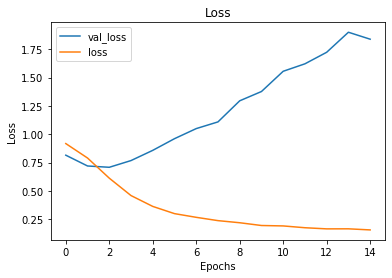

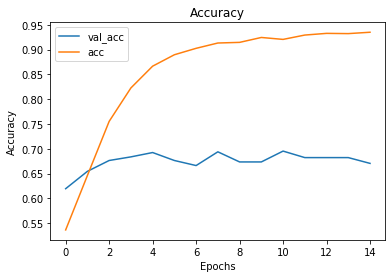

In [33]:
visualize_training_results(results)

## Model 2

For this model, these changes were made:
- Another Dense layer was added
- Dropout was reduced to 0.2
- Embedding output size was reduced to 50

In [34]:
model_2 = Sequential()

In [35]:
embedding_size = 50
model_2.add(Embedding(9398, embedding_size))
model_2.add(LSTM(25, return_sequences=True))
model_2.add(GlobalMaxPool1D())
model_2.add(Dropout(0.2))
model_2.add(Dense(100, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(3, activation='softmax'))

In [36]:
model_2.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [37]:
results_2 = model_2.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Train on 5484 samples, validate on 1371 samples
Epoch 1/15
5484/5484 [==============================] - 15s 3ms/step - loss: 0.8683 - acc: 0.6021 - val_loss: 0.8077 - val_acc: 0.6003
Epoch 2/15
5484/5484 [==============================] - 15s 3ms/step - loss: 0.7758 - acc: 0.6295 - val_loss: 0.7613 - val_acc: 0.6455
Epoch 3/15
5484/5484 [==============================] - 15s 3ms/step - loss: 0.6188 - acc: 0.7482 - val_loss: 0.7496 - val_acc: 0.6506
Epoch 4/15
5484/5484 [==============================] - 15s 3ms/step - loss: 0.4476 - acc: 0.8293 - val_loss: 0.7899 - val_acc: 0.6761
Epoch 5/15
5484/5484 [==============================] - 15s 3ms/step - loss: 0.3233 - acc: 0.8820 - val_loss: 0.8812 - val_acc: 0.6586
Epoch 6/15
5484/5484 [==============================] - 15s 3ms/step - loss: 0.2542 - acc: 0.9081 - val_loss: 0.9793 - val_acc: 0.6710
Epoch 7/15
5484/5484 [==============================] - 15s 3ms/step - loss: 0.2150 - acc: 0.9185 - val_loss: 1.0698 - val_acc: 0.6761
Epoch 8

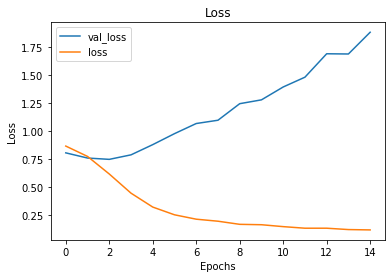

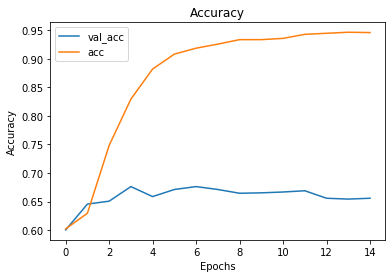

In [38]:
visualize_training_results(results_2)

## Model 3

This next network was drastically smaller to see if that beat out the overfitting.

Changes for this model:
- Remove a Dense layer
- Increase dropout
- Add a L2 regularization to Dense
- Change Dense activation to Tanh
- Embedding size to 100 (between first and second model values)

In [39]:
model_3 = Sequential()

In [40]:
embedding_size = 100
lambda_coeff = 0.01
model_3.add(Embedding(9398, embedding_size))
model_3.add(LSTM(25, return_sequences=True))
model_3.add(GlobalMaxPool1D())
model_3.add(Dropout(0.6))
model_3.add(Dense(50, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
model_3.add(Dropout(0.6))
model_3.add(Dense(3, activation='softmax'))

In [41]:
model_3.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [42]:
results_3 = model_3.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Train on 5484 samples, validate on 1371 samples
Epoch 1/15
5484/5484 [==============================] - 19s 3ms/step - loss: 1.0846 - acc: 0.5784 - val_loss: 0.9222 - val_acc: 0.6003
Epoch 2/15
5484/5484 [==============================] - 18s 3ms/step - loss: 0.8901 - acc: 0.6063 - val_loss: 0.8153 - val_acc: 0.6295
Epoch 3/15
5484/5484 [==============================] - 18s 3ms/step - loss: 0.7527 - acc: 0.6924 - val_loss: 0.7707 - val_acc: 0.6579
Epoch 4/15
5484/5484 [==============================] - 18s 3ms/step - loss: 0.6003 - acc: 0.7783 - val_loss: 0.7867 - val_acc: 0.6732
Epoch 5/15
5484/5484 [==============================] - 18s 3ms/step - loss: 0.4726 - acc: 0.8348 - val_loss: 0.8769 - val_acc: 0.6754
Epoch 6/15
5484/5484 [==============================] - 18s 3ms/step - loss: 0.3846 - acc: 0.8621 - val_loss: 0.9642 - val_acc: 0.6827
Epoch 7/15
5484/5484 [==============================] - 20s 4ms/step - loss: 0.3231 - acc: 0.8926 - val_loss: 1.0527 - val_acc: 0.6805
Epoch 8

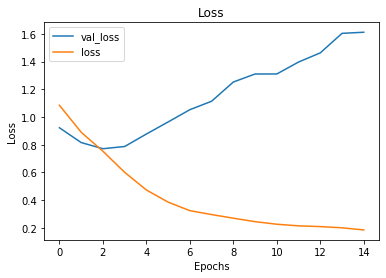

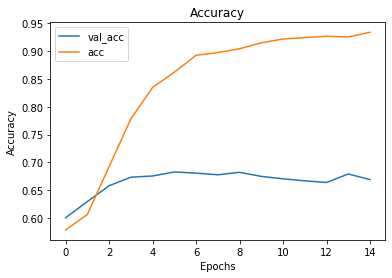

In [43]:
visualize_training_results(results_3)

## Model 4

Despite being smaller, the previous model didn't stop overfitting. Some more changes were tried.

Changing:
- Lambda coeff to 0.1 from 0.01
- Dropout to 0.4
- Batch size to 16

In [53]:
model_4 = Sequential()

In [54]:
embedding_size = 100
lambda_coeff = 0.1
model_4.add(Embedding(9398, embedding_size))
model_4.add(LSTM(25, return_sequences=True))
model_4.add(GlobalMaxPool1D())
model_4.add(Dropout(0.4))
model_4.add(Dense(50, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
model_4.add(Dropout(0.4))
model_4.add(Dense(3, activation='softmax'))

In [55]:
model_4.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [56]:
results_4 = model_4.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)

Train on 5484 samples, validate on 1371 samples
Epoch 1/30
5484/5484 [==============================] - 33s 6ms/step - loss: 1.7169 - acc: 0.5914 - val_loss: 0.8845 - val_acc: 0.6003
Epoch 2/30
5484/5484 [==============================] - 33s 6ms/step - loss: 0.8225 - acc: 0.6504 - val_loss: 0.7783 - val_acc: 0.6601
Epoch 3/30
5484/5484 [==============================] - 33s 6ms/step - loss: 0.6767 - acc: 0.7615 - val_loss: 0.7927 - val_acc: 0.6703
Epoch 4/30
5484/5484 [==============================] - 34s 6ms/step - loss: 0.5754 - acc: 0.8158 - val_loss: 0.8107 - val_acc: 0.6878
Epoch 5/30
5484/5484 [==============================] - 33s 6ms/step - loss: 0.5063 - acc: 0.8450 - val_loss: 0.8787 - val_acc: 0.6725
Epoch 6/30
5484/5484 [==============================] - 34s 6ms/step - loss: 0.4491 - acc: 0.8561 - val_loss: 0.9187 - val_acc: 0.6681
Epoch 7/30
5484/5484 [==============================] - 39s 7ms/step - loss: 0.3995 - acc: 0.8714 - val_loss: 1.0249 - val_acc: 0.6703
Epoch 8

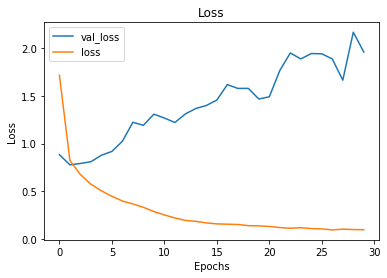

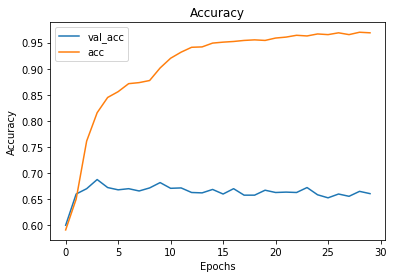

In [57]:
visualize_training_results(results_4)

## Model 5

Changing:
- Lambda to 0.0001
- Neurons to 200, without dropout first
- Relu instead of Tanh

In [58]:
model_5 = Sequential()

In [59]:
embedding_size = 100
lambda_coeff = 0.001
model_5.add(Embedding(9398, embedding_size))
model_5.add(LSTM(25, return_sequences=True))
model_5.add(GlobalMaxPool1D())
model_5.add(Dense(200, activation='relu', kernel_regularizer=regularizers.l2(lambda_coeff)))
model_5.add(Dense(3, activation='softmax'))

In [60]:
model_5.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [61]:
results_5 = model_5.fit(X_train, y_train, epochs=15, batch_size=30, validation_split=0.2)

Train on 5484 samples, validate on 1371 samples
Epoch 1/15
5484/5484 [==============================] - 25s 5ms/step - loss: 0.8680 - acc: 0.6089 - val_loss: 0.7774 - val_acc: 0.6557
Epoch 2/15
5484/5484 [==============================] - 23s 4ms/step - loss: 0.6778 - acc: 0.7254 - val_loss: 0.7648 - val_acc: 0.6710
Epoch 3/15
5484/5484 [==============================] - 24s 4ms/step - loss: 0.4919 - acc: 0.8115 - val_loss: 0.7873 - val_acc: 0.6856
Epoch 4/15
5484/5484 [==============================] - 21s 4ms/step - loss: 0.3609 - acc: 0.8709 - val_loss: 0.9002 - val_acc: 0.6608
Epoch 5/15
5484/5484 [==============================] - 21s 4ms/step - loss: 0.2784 - acc: 0.9010 - val_loss: 0.9165 - val_acc: 0.6761
Epoch 6/15
5484/5484 [==============================] - 21s 4ms/step - loss: 0.2261 - acc: 0.9174 - val_loss: 1.0529 - val_acc: 0.6601
Epoch 7/15
5484/5484 [==============================] - 22s 4ms/step - loss: 0.1954 - acc: 0.9322 - val_loss: 1.1186 - val_acc: 0.6637
Epoch 8

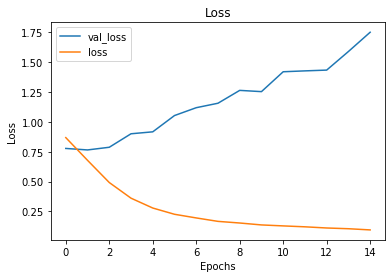

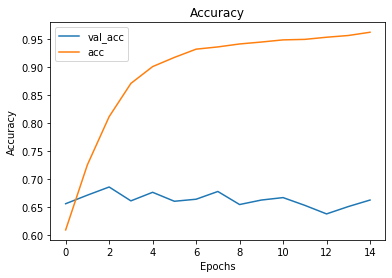

In [62]:
visualize_training_results(results_5)

## Model 6

Again, the overfitting was not really affected much at all.

Changes:
- Removed the large, regularized Dense layer altogether

In [63]:
model_6 = Sequential()

In [64]:
embedding_size = 100
model_6.add(Embedding(9398, embedding_size))
model_6.add(LSTM(25, return_sequences=True))
model_6.add(GlobalMaxPool1D())
model_6.add(Dense(3, activation='softmax'))

In [65]:
model_6.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [66]:
results_6 = model_6.fit(X_train, y_train, epochs=15, batch_size=30, validation_split=0.2)

Train on 5484 samples, validate on 1371 samples
Epoch 1/15
5484/5484 [==============================] - 25s 5ms/step - loss: 0.8637 - acc: 0.5963 - val_loss: 0.8139 - val_acc: 0.6003
Epoch 2/15
5484/5484 [==============================] - 23s 4ms/step - loss: 0.7599 - acc: 0.6772 - val_loss: 0.7508 - val_acc: 0.6630
Epoch 3/15
5484/5484 [==============================] - 22s 4ms/step - loss: 0.6069 - acc: 0.7834 - val_loss: 0.7427 - val_acc: 0.6703
Epoch 4/15
5484/5484 [==============================] - 22s 4ms/step - loss: 0.4615 - acc: 0.8381 - val_loss: 0.7676 - val_acc: 0.6907
Epoch 5/15
5484/5484 [==============================] - 22s 4ms/step - loss: 0.3575 - acc: 0.8811 - val_loss: 0.8158 - val_acc: 0.6761
Epoch 6/15
5484/5484 [==============================] - 22s 4ms/step - loss: 0.2896 - acc: 0.9048 - val_loss: 0.8932 - val_acc: 0.6674
Epoch 7/15
5484/5484 [==============================] - 22s 4ms/step - loss: 0.2471 - acc: 0.9130 - val_loss: 0.9336 - val_acc: 0.6710
Epoch 8

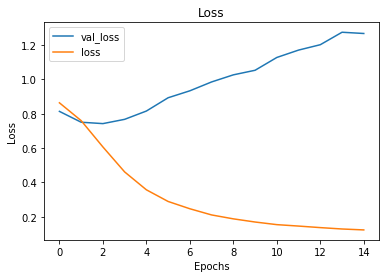

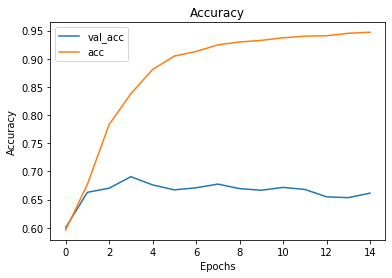

In [68]:
visualize_training_results(results_6)

## Model 7

Again, almost no change was seen, despite the drastic shift in architecture. My current goal here is to end this  disparity between acc and val_acc.

Changes:
- Using RMSprop optimizer
- Validation lowered to 0.1
- Removed final dropout layer
- Cut Dense layer size in half to 25

In [87]:
from keras.optimizers import RMSprop

In [88]:
model_7 = Sequential()

In [89]:
embedding_size = 100
lambda_coeff = 0.1
model_7.add(Embedding(9398, embedding_size))
model_7.add(LSTM(25, return_sequences=True))
model_7.add(GlobalMaxPool1D())
model_7.add(Dropout(0.4))
model_7.add(Dense(25, activation='tanh', kernel_regularizer=regularizers.l2(lambda_coeff)))
model_7.add(Dense(3, activation='softmax'))

In [91]:
model_7.compile(loss='categorical_crossentropy', 
                optimizer='RMSprop',
                metrics=['accuracy'])

In [92]:
results_7 = model_7.fit(X_train, y_train, epochs=15, batch_size=30, validation_split=0.1)

Train on 6169 samples, validate on 686 samples
Epoch 1/15
6169/6169 [==============================] - 33s 5ms/step - loss: 1.8135 - acc: 0.5965 - val_loss: 1.0361 - val_acc: 0.6195
Epoch 2/15
6169/6169 [==============================] - 31s 5ms/step - loss: 0.8772 - acc: 0.6392 - val_loss: 0.7864 - val_acc: 0.6691
Epoch 3/15
6169/6169 [==============================] - 32s 5ms/step - loss: 0.7470 - acc: 0.7145 - val_loss: 0.7759 - val_acc: 0.6574
Epoch 4/15
6169/6169 [==============================] - 32s 5ms/step - loss: 0.6835 - acc: 0.7486 - val_loss: 0.8543 - val_acc: 0.6181
Epoch 5/15
6169/6169 [==============================] - 32s 5ms/step - loss: 0.6352 - acc: 0.7706 - val_loss: 0.7597 - val_acc: 0.6778
Epoch 6/15
6169/6169 [==============================] - 32s 5ms/step - loss: 0.6086 - acc: 0.7883 - val_loss: 0.7596 - val_acc: 0.6953
Epoch 7/15
6169/6169 [==============================] - 31s 5ms/step - loss: 0.5815 - acc: 0.7967 - val_loss: 0.7476 - val_acc: 0.6910
Epoch 8/

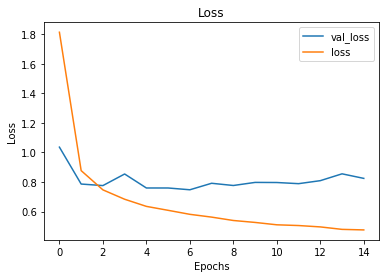

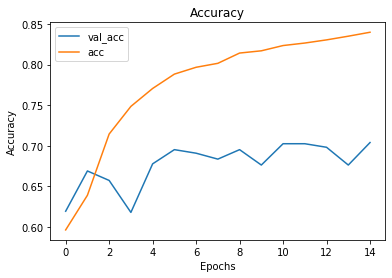

In [93]:
visualize_training_results(results_7)

# Model Summaries

Despite numerous attempts at changed architectures, these models had quite similar performances, with the last being the ***least*** overfit. It had the highest final validation accuracy, clocking in at **70.41%.** It also had the lowest validation loss at **82.47** (which honestly is not impressive). The training accuracy was actually the lowest at **83.98%,** and training loss was the highest at **47.60%.** In other words, this model did the ***absolute worst on the training data. But,*** it did do the **best** on the validation data. Apples and oranges.

In an ideal world, I would have started with RMSProp and spent my time tuning and training this model. And if I had more time, that's what I'd be doing now. I'm certain that when I return to this dataset, I'll be able to make a really tight, predictively-strong model off this new baseline architecture.

Nonetheless, I humbly announce **Model 7** as the somewhat-disappointing winner, provided you want accuracy on validation and test data, and I don't know why you wouldn't.